# Assembly of the z-movies captured by Light Sheet Fluorescent Microscopy in space and time

This notebook is the first to be executed in order to create a 3D video of the heart over a cardiac cycle.

**Use the environment "myenv" for this notebook"**

To do this, import the myenv.yml file into your Home directory. Open it and change the prefix /rds/general/user/ecd24/home/anaconda3/envs/myenv to your own (usually, you just need to change ecd24 to your username). Open a terminal and execute the command 'conda env create -f myenv.yml'.

In this example, the zebrafish heart was captured by a light sheet fluorescent microscope with a frequency of 150 im/sec on 201 slices. This microscope stopped at each slice and captured 1 second of images. The z-movies have been imported in my home directory can be found in the folder called 'Z-slices'.

## The basic procedures : 

A - Determination of the length of a cardiac cycle

B - Creation of new z-movies with 2 cycles (the first cycle is doubled)

C - Post-Processing

D - Determination of the time shifts between each z-movie 

E - Final assembly

# 0 - Import Packages

In [1]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np
import scipy.stats
import tifffile as tiff
from scipy.ndimage import gaussian_laplace
from statistics import mean
from scipy.ndimage import gaussian_filter, sobel
import os
import skimage.io as io

In [2]:
#Initialisations 

num_slices = 201  #Number of slices

## A - Determination of the length of a cardiac cycle

The first step of the assembly is to identify the number of images constituting a cardiac cycle. This was achieved using the Spearman correlation method. For instance, in one z-movie, we selected a reference image and compared it with every other 150 images of the z-movie using the scipy.stats.spearmanr() Python function. The first peak corresponds to the correlation with the reference image itself, while the second peak corresponds to the correlation with an image similar to the reference image in the next cycle. Therefore, the gap between the two peaks represents the length of one cardiac cycle.

By repeating this process for every image from z-movie 98 to 103, we plotted a graph showing the frequency of cycle lengths, from which we concluded that a cycle lasts 92 images.

This operation was performed only on z-movies 98 to 103 as they are located towards the middle of the heart. Deformations related to contraction are more easily observable, thus making the identification of the length of the cardiac cycle more precise. If images from the extremities were chosen, there would be more black pixels related to the image background than pixels representing the hearts, which would have made the correlation less reliable.

global_length_cycle_list: [93, 93, 93, 93, 93, 93, 93, 93, 92, 94, 93, 93, 93, 92, 93, 93, 94, 93, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 92, 92, 92, 92, 92, 93, 92, 92, 93, 93, 92, 93, 92, 92, 93, 93, 92, 93, 92, 93, 92, 93, 93, 93, 93, 92, 93, 93, 93, 93, 93, 92, 92, 92, 93, 93, 94, 93, 93, 92, 93, 93, 93, 93, 93, 92, 93, 94, 92, 91, 91, 92, 91, 92, 93, 92, 85, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 91, 91, 93, 93, 92, 93, 92, 92, 91, 92, 92, 91, 94, 94, 94, 93, 94, 95, 94, 95, 94, 95, 94, 95, 94, 95, 94, 95, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 94, 94, 94, 92, 95, 95, 94, 93, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 94]
length_cycle_with_max_freq: 92


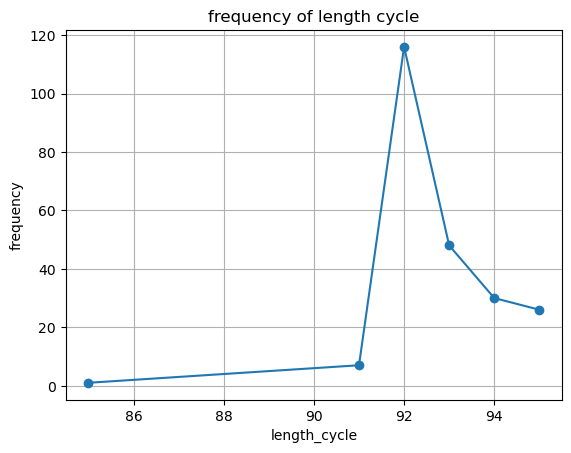

In [4]:
# execution time : between 20 and 30 min

# Initialisations
z_slice_dict = {}

#z_slice_tab_dict = {}

z_slice_list_dict = {}

z_slice_length_cycle_dict = {}

global_length_cycle_list = []

# 1 - Loop 'for i' to open all z slices.
# 2 - Nested loops 'for j' and 'for k' to calculate the correlation between all images for all z-movies.

lower_bound = int(num_slices/2) - 2
upper_bound = int(num_slices/2) + 3

for i in range(lower_bound, upper_bound):
    my_tif_file = f'Z-slices/z_slice_{i}.tif'
    z_slice_dict[f'z_slice_{i}'] = imageio.volread(my_tif_file)  # Store the images in the dictionary
    z_slice_length_cycle_dict[f'length_cycle_z_slice_{i}'] = []

    for j in range(len(z_slice_dict[f'z_slice_{i}'])):
        reference_image = z_slice_dict[f'z_slice_{i}'][j] # Choose image [j] as the reference image for z-movie i
        list_px_reference_image = reference_image.flatten() # Convert all pixels of the reference image to a 1-D array, required for calculating spearmanr
        
        z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}']=[] #fill up a list with every correlation value between a reference image and every other of the z-movie
        
        #number_of_p_value_Spearman = 0

        for k in range(len(z_slice_dict[f'z_slice_{i}'])):
            current_image =z_slice_dict[f'z_slice_{i}'][k] # for one ref image j, iterate through all images k of a z-movie i
            list_px_current_image = current_image.flatten() # Convert all pixels of the reference image to a 1-D array, required for calculating spearmanr
            corr_k, p_value_k = scipy.stats.spearmanr(list_px_reference_image, list_px_current_image)
            z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'].append(corr_k)

            #if p_value_k < 0.05:
            #    number_of_p_value_Spearman += 1


        # 3 - Calculate the cycle length for each z-movie
        z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'] = z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][np.argmax(z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}']):] 
        # We cut each list so that index 0 represents the correlation value of the reference image with itself.
        # Therefore, the index of the second peak will be equal to the number of images in the cycle.
        
        # Identification of the second peak :
        maxi = 0
        for m in range(1, len(z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}']) - 1):
            if (
                z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m] > z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m - 1]
                and z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m] > z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m + 1]
                and 0.9 < z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m] 
                and z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m] < 1
                and z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m] > maxi
            ):
                maxi = z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][m]
                max_index = z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'].index(maxi)

        if maxi != 0:
            #print("maxi :",maxi)
            #print("max_index :", max_index)
            z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'] = z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}'][:max_index] # No +1 because in Python, the slicing operator ":" does not include the element at the end index.
            #print("length :", len(z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}']))
            z_slice_length_cycle_dict[f'length_cycle_z_slice_{i}'].append(len(z_slice_list_dict[f'liste_spearmanr_z_slice_{i}_imref_{j}']))
        else:
            pass # Do not add anything because there is no complete cycle.
        
    # 4 - Plot a frequency graph for all combined z-movies (x-axis: number of images per cycle, y-axis: frequency)
    # Use numpy.unique to get unique values and their frequencies
    global_length_cycle_list += z_slice_length_cycle_dict[f'length_cycle_z_slice_{i}']
    
print("global_length_cycle_list:", global_length_cycle_list)

length_cycle, freq = np.unique(global_length_cycle_list, return_counts=True)
length_cycle_with_max_freq = length_cycle[np.argmax(freq)]
print("length_cycle_with_max_freq:",length_cycle_with_max_freq)
plt.plot(length_cycle, freq, marker='o', linestyle='-')
plt.xlabel('length_cycle')
plt.ylabel('frequency')
plt.title('frequency of length cycle')
plt.grid(True)
plt.show()



initialize the length of the cycle found with the program

In [ ]:
length_cycle_with_max_freq = 92

# B - Creation of new z-movies with 2 cycles (the first cycle is doubled)

Before determining the time shift between each z-movie, the z-movies need to be prepared. To do this, we created a new folder called ‘z-slices_doubled’ and wrote a code that takes all the z-slices, cuts them at the end of the cycle and doubles the number of images to obtain two complete cardiac cycles. This allows step ‘D - Determination of time shifts between each z-movie’ to use all the images from the first cycle of a z-slice{i} as reference images and compare them with those from the next z-movie.

If, in step D, we had decided to compare only the images in the ‘z-slices’ folder of movie z{i} with those of movie z{i+1}  without this extension step, we would have had problems determining the shift. Indeed, the z-slices have between 1 and 2 cycles, which means that for images n°93 to 150, we would have had complications, so it was preferable to delete them and double the first entire cycle. 

In [1]:
# execution time : between 20 and 30 min

# Initialisations
z_slice_dict = {}

#z_slice_tab_dict = {}

z_slice_list_dict = {}

# 1 - Loop 'for i' to open all z slices.
# 2 - Nested loops 'for k' to calculate the correlation between all images for all z-movies.

for i in range(0,num_slices):
    my_tif_file = f'Z-slices/z_slice_{i}.tif' 
    z_slice_dict[f'z_slice_{i}'] = imageio.volread(my_tif_file)  # Store the images in the dictionary
    additional_images = z_slice_dict[f'z_slice_{i}'][0:length_cycle_with_max_freq] #add one cardiac cycle
    z_slice_dict[f'z_slice_{i}_doubled'] = np.concatenate([additional_images, additional_images]) # 150 im + 1 cycle

    # Path to save the file
    output_path = f'Z-slices_doubled/z_slice_{i}_doubled.tif'

    # Save all the images
    imageio.volwrite(output_path, z_slice_dict[f'z_slice_{i}_doubled'])
    print(z_slice_dict[f'z_slice_{i}_doubled'].shape)
    
        

(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 320, 300)
(184, 32

# C - Post-Processing 

We applied a filter to all Z-movies to effectively reduce noise and enhance nuclei detection. In this way, the determination of the shifts between each z-movie will be more accurate than with raw z-movies. In our z-movies, Laplacian of Gaussian (LoG) processing had a better result than the Gaussian and Derivative filter. 

## 1 - Laplacian of Gaussian (recommended)


In [1]:
z_slice_dict = {}

def apply_laplacian_of_gaussian_3d(image, sigma=2.0):
    return gaussian_laplace(image, sigma=sigma)

# Iterate over the slices (z values from 0 to 200)
for z in range(num_slices):
    path = f'Z-slices_doubled/z_slice_{z}_doubled.tif'
    image = imageio.volread(path)  # Read the volume image
    image = image.astype('float32')
    z_slice_dict[f'z_slice_{z}_doubled_processed'] = []
    
    # Apply the Laplacian of Gaussian filter
    log_image_3d = apply_laplacian_of_gaussian_3d(image, sigma=2.0)
    log_image_3d = - log_image_3d
    
    z_slice_dict[f'z_slice_{z}_doubled_processed'].append(log_image_3d)
    
    # Path to save the file
    output_path = f'Z-slices_doubled_processed/z_slice_{z}_doubled_processed.tif'
    
    # Save the processed image
    tiff.imwrite(output_path, log_image_3d.astype(np.float32))
    print(f"Processed shape for z_slice_{z}_doubled_processed: {log_image_3d.shape}")


Processed shape for z_slice_0_doubled_processed: (184, 320, 300)
Processed shape for z_slice_1_doubled_processed: (184, 320, 300)
Processed shape for z_slice_2_doubled_processed: (184, 320, 300)
Processed shape for z_slice_3_doubled_processed: (184, 320, 300)
Processed shape for z_slice_4_doubled_processed: (184, 320, 300)
Processed shape for z_slice_5_doubled_processed: (184, 320, 300)
Processed shape for z_slice_6_doubled_processed: (184, 320, 300)
Processed shape for z_slice_7_doubled_processed: (184, 320, 300)
Processed shape for z_slice_8_doubled_processed: (184, 320, 300)
Processed shape for z_slice_9_doubled_processed: (184, 320, 300)
Processed shape for z_slice_10_doubled_processed: (184, 320, 300)
Processed shape for z_slice_11_doubled_processed: (184, 320, 300)
Processed shape for z_slice_12_doubled_processed: (184, 320, 300)
Processed shape for z_slice_13_doubled_processed: (184, 320, 300)
Processed shape for z_slice_14_doubled_processed: (184, 320, 300)
Processed shape for 

## 2 - Gaussian and Derivative

In [ ]:
z_slice_dict = {}

def apply_gaussian_filter_3d(image, sigma=2.0):
    return gaussian_filter(image, sigma=sigma)

def apply_derivative_filter_3d(image):
    # Calculate the derivatives in each direction
    dt = sobel(image, axis=0)
    dx = sobel(image, axis=2)
    dy = sobel(image, axis=1)
    
    # Magnitude of the gradient
    grad = np.sqrt(dt**2 + dx**2 + dy**2)
    return grad

# Iterate over the second dimension (t values from 0 to 200)
for z in range(num_slices):
    path = f'Z-slices_doubled/z_slice_{z}_doubled.tif'
    image = imageio.volread(path)  # Read the volume image
    image = image.astype('float32')
    z_slice_dict[f'z_slice_{z}_doubled_processed'] = []
    
    blurred_image_3d = apply_gaussian_filter_3d(image, sigma=2.0)
    processed_image_3d = apply_derivative_filter_3d(blurred_image_3d)
    
    z_slice_dict[f'z_slice_{z}_doubled_processed'].append(processed_image_3d)
#     z_slice_dict[f'z_slice_{z}_doubled_processed'].append(blurred_image_3d)
    
    # Path to save the file
    output_path = f'Z-slices_doubled_processed/z_slice_{z}_doubled_processed.tif'
    
    # Save the processed image
    tiff.imwrite(output_path, processed_image_3d.astype(np.float32))
#     tiff.imwrite(output_path, blurred_image_3d.astype(np.float32))
    print(f"Processed shape for z_slice_{z}_doubled_processed: {processed_image_3d.shape}")
#     print(f"Processed shape for z_slice_{z}_doubled_processed: {blurred_image_3d.shape}")


# D - Determination of the time shifts between each z-movie

Using the Spearman correlation function, we also determined the temporal shift between each Z-movie. We compared a reference image from Z-movie processed i with all the images in Z-movie processed i + 1, and the shift was defined as the difference between the image number in Z-movie i + 1 that had the highest correlation with the reference image of the Z-movie processed i, and the number of the reference image itself. This process was repeated with every image in each Z-movie processed, where each image served as a reference. We calculated shift frequencies for each Z-movie processed and compiled the shifts with the maximum frequency into a list of shifts.

In [8]:
# Initialisations
z_slice_dict = {}


z_slice_list_corr_dict = {}

list_shift_z_slices = {}

list_shift_with_max_freq = []

list_argmax = []

# Function to save the results in a text file
def save_results_to_file(filename, shift, freq, shift_with_max_freq, list_shift_with_max_freq):
    with open(filename, 'a') as f:
        f.write(f"shift: {shift}\n")
        f.write(f"freq: {freq}\n")
        f.write(f"shift_with_max_freq_LoG: {shift_with_max_freq}\n")
        f.write("\n")
    with open(filename, 'a') as f:
        f.write(f"list_shift_with_max_freq_LoG: {list_shift_with_max_freq}\n")

# Output file name
output_filename = 'list_shift_with_max_freq_LoG.txt'

# Opening the z-slices // two by two
for i in range(0,num_slices - 1): 
    my_tif_file_doubled_processed_i = f'Z-slices_doubled_processed/z_slice_{i}_doubled_processed.tif' # Define z-movie file path
    z_slice_dict[f'z_slice_{i}'] = imageio.volread(my_tif_file_doubled_processed_i) # Store the images in the dictionary
    my_tif_file_doubled_processed_i_plus_1 = f'Z-slices_doubled_processed/z_slice_{i+1}_doubled_processed.tif' # Define z-movie file path
    z_slice_dict[f'z_slice_{i+1}'] = imageio.volread(my_tif_file_doubled_processed_i_plus_1)
    print(f'{i+1}',(len(z_slice_dict[f'z_slice_{i+1}'])))  # See how the algorithm progresses
    
    z_slice_list_corr_dict[f'list_spearmanr_z_slice_{i}_imref{100}_with_z_slice_{i+1}'] = [] # Create a list to store correlations between imref0 of a z-movie i and all the images of z-movie i+1
    list_shift_z_slices[f'shift_z_slice{i}_and_z_slice{i+1}'] = [] # Create a list to store the shifts between the z-movies i and i+1
    reference_image = z_slice_dict[f'z_slice_{i}'][100] # Open the imref
    list_px_reference_image = reference_image.flatten() # Convert all pixels of the reference image to a 1-D array, required for calculating spearmanr
    
    for k in range(len(z_slice_dict[f'z_slice_{i+1}'])):
        current_image = z_slice_dict[f'z_slice_{i+1}'][k] # for the imref0, iterate through all images k of a z-movie {i+1}_bis
        list_px_current_image = current_image.flatten() # Convert all pixels of the reference image to a 1-D array, required for calculating spearmanr
        corr_k, p_value_k = scipy.stats.spearmanr(list_px_reference_image, list_px_current_image) # Calculate Spearman correlation between imref0 of z-movie i and all images of z-slice i+1
        z_slice_list_corr_dict[f'list_spearmanr_z_slice_{i}_imref{100}_with_z_slice_{i+1}'].append(corr_k) # Add corr_k to the list
        #lk.append(k)
    
    the_max = np.argmax(z_slice_list_corr_dict[f'list_spearmanr_z_slice_{i}_imref{100}_with_z_slice_{i+1}'][:length_cycle_with_max_freq]) 
    list_argmax. append(the_max) # For each comparison of each imref0 from z-movie i with all the images of z-movie i+1, store the shift (since the index of the image corresponding to the max is also the shift)
    mean_shift_imref100 = mean(list_argmax) # Calculate the average of the shifts
    

    for j in range(0,length_cycle_with_max_freq):
        reference_image = z_slice_dict[f'z_slice_{i}'][j] # Select one ref image j
        list_px_reference_image = reference_image.flatten() # Convert all pixels of the reference image to a 1-D array, required for calculating spearmanr
        e = round(mean_shift_imref100/3) # Create an interval
        z_slice_list_corr_dict[f'list_spearmanr_z_slice_{i}_imref{j}_avec_z_slice_{i+1}']=[0]*(j + mean_shift_imref100 - e) # Create a list of zeros with a size equal to the lower margin of the interval
        
        for k in range(j + mean_shift_imref100 - e, j + mean_shift_imref100 + e + 1): 
            current_image =z_slice_dict[f'z_slice_{i+1}'][k] # for image {j}, iterate through all images k of a z-movie {i}
            list_px_current_image = current_image.flatten() # Convert all pixels of the reference image to a 1-D array, required for calculating spearmanr
            corr_k, p_value_k = scipy.stats.spearmanr(list_px_reference_image, list_px_current_image) # Calculate Spearman correlation between image {j} of z-movie i and all images of z-slice i+1
            z_slice_list_corr_dict[f'list_spearmanr_z_slice_{i}_imref{j}_avec_z_slice_{i+1}'].append(corr_k)
                    
        indice_max = np.argmax(z_slice_list_corr_dict[f'list_spearmanr_z_slice_{i}_imref{j}_avec_z_slice_{i+1}'])
        element_colonne_1 = j
        element_colonne_2 = indice_max
        element_colonne_3 = (element_colonne_2 - element_colonne_1)
        list_shift_z_slices[f'shift_z_slice{i}_and_z_slice{i+1}'].append(element_colonne_3)
        

    shift, freq = np.unique(list_shift_z_slices[f'shift_z_slice{i}_and_z_slice{i+1}'], return_counts=True)
    shift_with_max_freq = shift[np.argmax(freq)]
    print ("shift :", shift)
    print("freq :", freq)
    print("shift_with_max_freq :", shift_with_max_freq)
    list_shift_with_max_freq.append(shift_with_max_freq)

    
print("list_argmax:", list_argmax)
print("mean shift imref100:", mean_shift_imref100)

print("list_shift_with_max_freq:", list_shift_with_max_freq)
print("length of the shift list:", len(list_shift_with_max_freq))

# Save the final result in the text file
with open(output_filename, 'a') as f:
    f.write(f"list_shift_with_max_freq_LoG: {list_shift_with_max_freq}\n")


# Result for "for i in range(116,120)" with explanation:

# shift: [33 34 35 36 37] I compare the images of z-movie 116 with those of z-movie 117, and I look at the shifts and their frequency.
# Freq: [ 2 30 70 45  2] 2+30+70+45+2=149 shifts
# shift with max frequency: 35 I look at the shift with the highest frequency and store it in the list "list_shift_with_max_freq"
# shift: [33 34 35 36 37] I compare the images of z-movie 117 with those of z-movie 118, and I look at the shifts and their frequency.
# Freq: [ 5  9 51 55 29] ...
# Gap with max frequency: 36 ...
# shift: [36 37 38 39] ...
# Freq: [61 24 53 11]
# shift with max frequency: 36
# shift: [36 37 38 39 40 41 42]
# Freq: [ 1  2 10 72 53  9  2]
# shift with max frequency: 39
# list_shift_with_max_freq: [35, 36, 36, 39] list of shifts with max frequency for z-movies 116 117 118 119
# Length of the gap list: 4



1 184
shift : [33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49 56 58 62 63]
freq : [ 5  2  5 18 15  7  6  5  7  5  3  1  2  1  5  1  1  1  1  1]
shift_with_max_freq : 36
2 184
shift : [32 33 34 35 36 37 38 39 42 43 44 45]
freq : [ 4  3  5  4  7 21 36  8  1  1  1  1]
shift_with_max_freq : 38
3 184
shift : [33 34 35 36 37 38 39 40 41 42 44]
freq : [ 5  7 13 13  6  7 16 18  3  3  1]
shift_with_max_freq : 40
4 184
shift : [33 34 35 36 37 38 39 40 41 42]
freq : [ 1  5  9 23  8 12 12 15  5  2]
shift_with_max_freq : 36
5 184
shift : [32 33 34 35 36 37 38 39 40 41 42 43 44 45]
freq : [ 2  5  8  9  9  5 16 23  4  1  3  2  3  2]
shift_with_max_freq : 39
6 184
shift : [32 33 34 35 36 37 38 39 40 41 42]
freq : [ 8  4  6 36 16  9  8  2  1  1  1]
shift_with_max_freq : 35
7 184
shift : [31 32 33 34 35 36 37 38 39 40 41 42 44 45 46]
freq : [ 2  3  4  4  6 10 25 19  5  3  6  2  1  1  1]
shift_with_max_freq : 37
8 184
shift : [34 35 36 37 38 39 40 41 42 43 45]
freq : [ 3 12 16 17 12 13  6  5  5  2  1]
s

## E - Final assembly

open the file list_shift_with_max_freq_LoG.txt and retrieve the last list in the file. Copy and paste it to initialize list_shift_with_max_freq 

In [ ]:
list_shift_with_max_freq = [36, 38, 40, 36, 39, 35, 37, 37, 38, 37, 36, 40, 36, 35, 35, 33, 35, 36, 35, 35, 36, 35, 36, 35, 37, 35, 37, 36, 37, 35, 34, 34, 36, 36, 35, 34, 35, 34, 34, 34, 34, 35, 36, 36, 35, 35, 34, 35, 35, 33, 34, 34, 36, 34, 34, 34, 35, 34, 34, 34, 35, 32, 34, 34, 34, 36, 35, 35, 33, 34, 35, 33, 33, 34, 32, 35, 35, 33, 33, 33, 38, 35, 35, 35, 35, 37, 34, 35, 36, 36, 35, 36, 36, 36, 39, 36, 36, 38, 37, 39, 37, 36, 37, 34, 37, 37, 36, 36, 37, 36, 35, 38, 35, 35, 36, 38, 35, 35, 36, 39, 37, 35, 37, 37, 37, 37, 37, 36, 37, 39, 36, 35, 36, 36, 37, 40, 38, 38, 37, 38, 35, 37, 36, 36, 35, 37, 37, 39, 37, 37, 36, 41, 36, 38, 39, 40, 37, 37, 38, 39, 37, 37, 41, 40, 40, 38, 40, 37, 38, 36, 41, 37, 38, 41, 37, 39, 36, 41, 40, 40, 40, 38, 41, 41, 41, 43, 44, 42, 38, 42, 38, 39, 41, 42, 41, 37, 42, 37, 42, 45]

In [9]:
z_slice_dict = {}


z_slice_list_dict = {}


list_shift_with_max_freq.insert(0, 0)

for j in range (1,num_slices):
    list_shift_with_max_freq[j] = list_shift_with_max_freq[j] + list_shift_with_max_freq[j-1]
    if list_shift_with_max_freq[j] > length_cycle_with_max_freq  :
        list_shift_with_max_freq[j] = list_shift_with_max_freq[j] - length_cycle_with_max_freq 
        
print(list_shift_with_max_freq)


# Loop "For" to open all the z slices and crop them to obtain a single cycle

my_tif_file = f'Z-slices/z_slice_{0}.tif' 
z_slice_dict[f'z_slice_{0}'] = imageio.volread(my_tif_file)  # Store the images in the dictionary
z_slice_dict[f'z_slice_{0}_un_cycle'] = z_slice_dict[f'z_slice_{0}'][:length_cycle_with_max_freq] # No +1 because in Python, the slicing operator does not include the element at the end index. So, we go from 0 to 91, which is 92 images. 

new_path = f'Z-slices_un_cycle/z_slice_{0}_un_cycle.tif'
imageio.volwrite(new_path, z_slice_dict[f'z_slice_{0}_un_cycle'])


for i in range(1,num_slices):
    my_tif_file = f'Z-slices/z_slice_{i}.tif' 
    z_slice_dict[f'z_slice_{i}'] = imageio.volread(my_tif_file)  
    z_slice_recoupees = z_slice_dict[f'z_slice_{i}'][list_shift_with_max_freq[i]:length_cycle_with_max_freq] # No +1 because in Python, the slicing operator does not include the element at the end index. So, we go from 0 to 91, which is 92 images. 
    
    decalage = z_slice_dict[f'z_slice_{i}'][:list_shift_with_max_freq[i]]
    z_slice_dict[f'z_slice_{i}_un_cycle'] = np.concatenate([z_slice_recoupees, decalage])
    #print(z_slice_dict[f'z_slice_{i}_un_cycle'].shape)
    
    new_path = f'Z-slices_un_cycle/z_slice_{i}_un_cycle.tif'
    imageio.volwrite(new_path, z_slice_dict[f'z_slice_{i}_un_cycle'])

# Assembly
slices_dataset = []

for j in range(num_slices):
    tiff_file_path = f'Z-slices_un_cycle/z_slice_{j}_un_cycle.tif'
    tiff_data = imageio.volread(tiff_file_path)
    slices_dataset.append(tiff_data)

#slices_dataset = np.asarray(slices_dataset)  # TZYX
slices_dataset = np.array(slices_dataset)  # TZYX
slices_dataset = np.expand_dims(slices_dataset, axis=2)  # TZCYX
slices_dataset = np.swapaxes(slices_dataset, 0, 1)  # ZTCYX
#print(slices_dataset.shape)
        
io.imsave('3d_with_time_heart_LoG.ome.tif', slices_dataset.astype('uint16'), imagej=True) 

[0, 36, 74, 22, 58, 5, 40, 77, 22, 60, 5, 41, 81, 25, 60, 3, 36, 71, 15, 50, 85, 29, 64, 8, 43, 80, 23, 60, 4, 41, 76, 18, 52, 88, 32, 67, 9, 44, 78, 20, 54, 88, 31, 67, 11, 46, 81, 23, 58, 1, 34, 68, 10, 46, 80, 22, 56, 91, 33, 67, 9, 44, 76, 18, 52, 86, 30, 65, 8, 41, 75, 18, 51, 84, 26, 58, 1, 36, 69, 10, 43, 81, 24, 59, 2, 37, 74, 16, 51, 87, 31, 66, 10, 46, 82, 29, 65, 9, 47, 84, 31, 68, 12, 49, 83, 28, 65, 9, 45, 82, 26, 61, 7, 42, 77, 21, 59, 2, 37, 73, 20, 57, 92, 37, 74, 19, 56, 1, 37, 74, 21, 57, 92, 36, 72, 17, 57, 3, 41, 78, 24, 59, 4, 40, 76, 19, 56, 1, 40, 77, 22, 58, 7, 43, 81, 28, 68, 13, 50, 88, 35, 72, 17, 58, 6, 46, 84, 32, 69, 15, 51, 92, 37, 75, 24, 61, 8, 44, 85, 33, 73, 21, 59, 8, 49, 90, 41, 85, 35, 73, 23, 61, 8, 49, 91, 40, 77, 27, 64, 14, 59]


/var/tmp/pbs.9674905.pbs/ipykernel_840221/2067695665.py:70: UserWarning: 3d_with_time_heart_LoG.ome.tif is a low contrast image
  io.imsave('3d_with_time_heart_LoG.ome.tif', slices_dataset.astype('uint16'), imagej=True)
